In [1]:
import copy
import glob
import os
import time
from collections import deque
import csv

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.icm import ICM
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.utils import get_vec_normalize, update_linear_schedule
from a2c_ppo_acktr.visualize import visdom_plot

In [2]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [3]:
norm_pos = 3150
num_proc = 1
eval_envs = make_vec_envs(
    'SuperMarioBrosNoFrameskip-1-1-v0', 1, num_proc,
    0.9, '', False, device, True, 'dense')

actor_critic = torch.load('./trained_models/ppo/SuperMarioBrosNoFrameskip-1-1-v0.pt')[0]
actor_critic.to(device)



vec_norm = get_vec_normalize(eval_envs)
if vec_norm is not None:
    vec_norm.eval()
    vec_norm.ob_rms = get_vec_normalize(envs).ob_rms

eval_episode_rewards = []

obs = eval_envs.reset()
eval_recurrent_hidden_states = torch.zeros(num_proc,
                actor_critic.recurrent_hidden_state_size, device=device)

eval_masks = torch.zeros(num_proc, 1, device=device)
positions = deque(maxlen=400)

while len(eval_episode_rewards) < 1:
    with torch.no_grad():

        _, action, _, eval_recurrent_hidden_states = actor_critic.act(
            obs, eval_recurrent_hidden_states, eval_masks, deterministic=True)

    # Obser reward and next obs
    obs, reward, done, infos = eval_envs.step(action)
    eval_envs.render()

    eval_masks = torch.FloatTensor([[0.0] if done_ else [1.0]
                                    for done_ in done]).cuda()
    

    for i, finished in enumerate(done):
        if finished:
            percentile = infos[i]['x_pos']/norm_pos
            eval_episode_rewards.append(percentile)
            with open(eval_file, 'a', newline='') as sfile:
                writer = csv.writer(sfile)
                writer.writerows([[percentile]])

    #to prevent the agent from getting stuck
    positions.append(infos[0]['x_pos'])
    pos_ar = np.array(positions)
    if (len(positions) >= 200) and (pos_ar < pos_ar[-1] + 20).all() and (pos_ar > pos_ar[-1] - 20).all():
        percentile = infos[0]['x_pos']/norm_pos
        eval_episode_rewards.append(percentile)
        with open(eval_file, 'a', newline='') as sfile:
            writer = csv.writer(sfile)
            writer.writerows([[percentile]])

eval_envs.close()
positions.clear()


NameError: name 'eval_file' is not defined

In [10]:
import pandas as pd
import numpy as np

In [6]:
import glob 
path ='./log_dir/model_ppo_dense/' # use your path
default = glob.glob(path + "train*.csv")

In [8]:
list_ = []

for file_ in default:
    df = pd.read_csv(file_, header=None)
    list_.append(df)

frame_def = pd.concat(list_, axis = 1, ignore_index = True)

In [12]:
means_def = np.nanmean(frame_def.values, axis=1)
std_def = np.nanstd(frame_def.values, axis=1)
maxi_def = np.nanmax(frame_def.values, axis=1)
mini_def = np.nanmin(frame_def.values, axis=1)
n_itr_def = frame_def.shape[0]

In [17]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

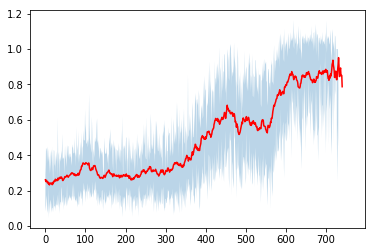

In [19]:
import matplotlib.pyplot as plt
plt.plot(moving_average(means_def[:-10], 10), color='red')
plt.fill_between(np.arange(n_itr_def), means_def + std_def, means_def - std_def , alpha=0.3 )
plt.show()

In [253]:
std_cur[-50:].mean()

197.67031776433024

In [254]:
std_def[-50:].mean()

257.44480344418326